# **Import Libraries**

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix

# **Load and Prepare Data**

In [ ]:
drive.mount("/content/drive")

# Load the data using pandas
data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

print("Data shape:", data.shape)
print("Data head:", data.head())





# **Data Analysis**

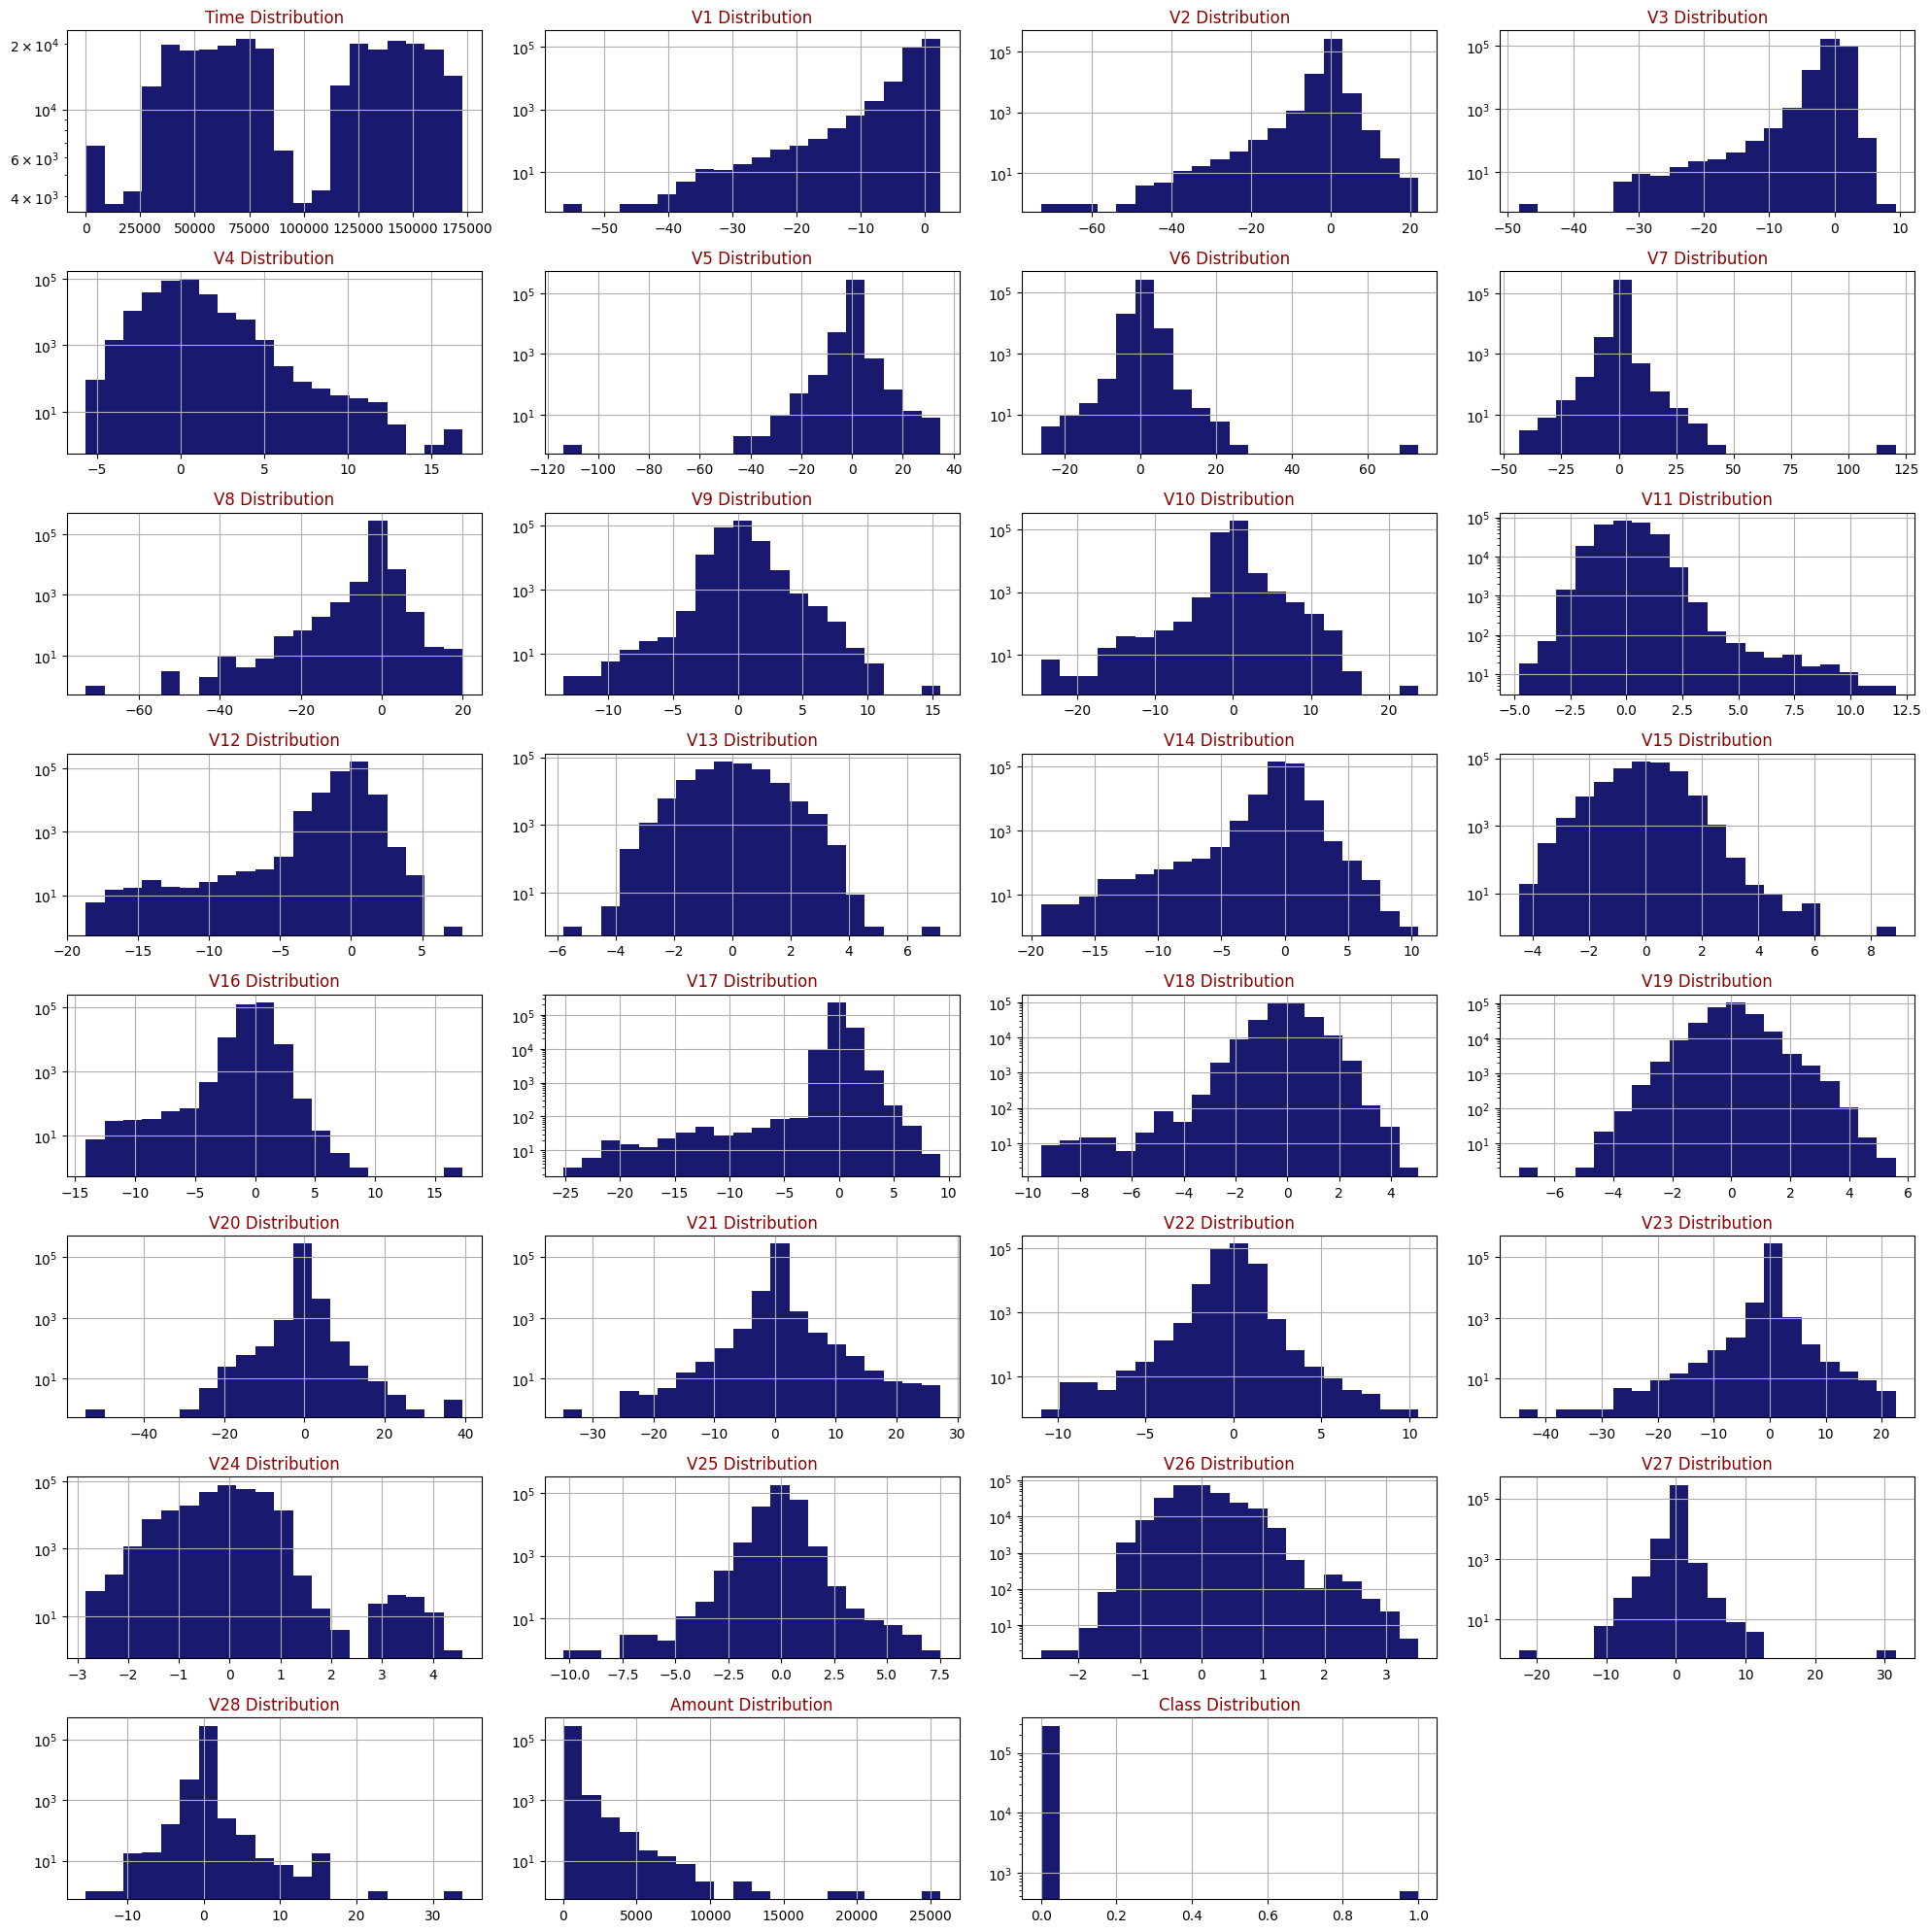

In [ ]:
import matplotlib.pyplot as plt

def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i + 1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(f"{feature} Distribution", color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()

draw_histograms(data, data.columns, 8, 4)


# **Preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

X = data.drop('Class', axis=1)
y = data['Class']

scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **PyTorch Logistic Regression Model**

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# **Train Model**

In [ ]:
model = LogisticRegressionModel(X_train_tensor.shape[1])

criterion = nn.BCELoss(reduction='none')

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.01)

# Training loop with class weights
def train_model(model, criterion, optimizer, train_loader, class_weights, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()

            # Compute weighted loss
            weights = y_batch * class_weights[1] + (1 - y_batch) * class_weights[0]
            loss = criterion(outputs, y_batch)
            weighted_loss = (loss * weights).mean()

            # Backward and optimize
            weighted_loss.backward()
            optimizer.step()
            total_loss += weighted_loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

train_model(model, criterion, optimizer, train_loader, class_weights)

Epoch [1/10], Loss: 0.2370
Epoch [2/10], Loss: 0.1657
Epoch [3/10], Loss: 0.1660
Epoch [4/10], Loss: 0.1678
Epoch [5/10], Loss: 0.1661
Epoch [6/10], Loss: 0.1670
Epoch [7/10], Loss: 0.1683
Epoch [8/10], Loss: 0.1653
Epoch [9/10], Loss: 0.1601
Epoch [10/10], Loss: 0.1693


# **Evalutate our model**

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            y_true.extend(y_batch.numpy())
            y_scores.extend(outputs.numpy())

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    print(f'Precision-Recall AUC: {pr_auc:.4f}')

evaluate_model(model, test_loader)

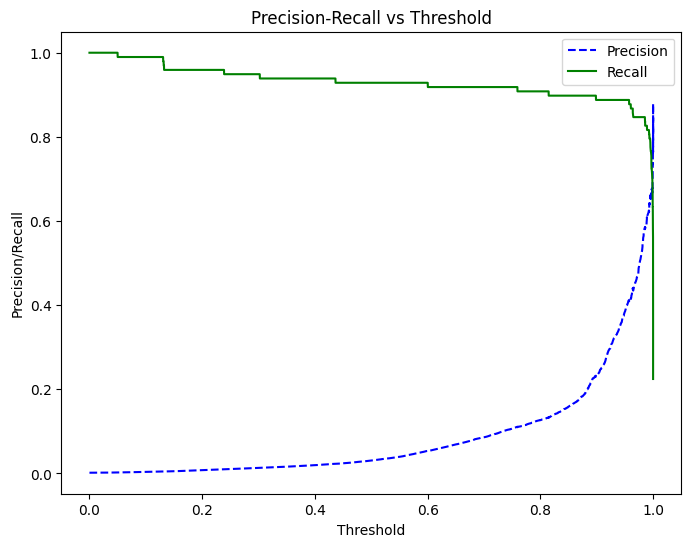

Best Threshold: 0.99


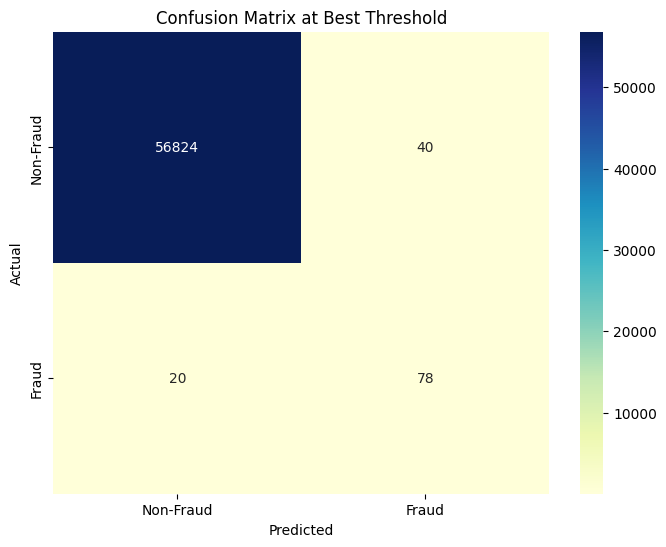

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Get model predictions
y_scores = model(X_test_tensor).detach().numpy().squeeze()

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

# Determine the best threshold (e.g., maximizing F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best Threshold: {best_threshold:.2f}')

# Convert scores to binary predictions using the best threshold
y_pred_best_threshold = (y_scores >= best_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_threshold)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix at Best Threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



